In [1]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib as mpl
import scipy.stats as spstats

In [2]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg
import analyze2p.scatter as sct

In [3]:
aggregate_dir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data'
pplot.set_plot_params()
scatter_kws={'s':2}

In [4]:
# Metadata
visual_areas=['V1', 'Lm', 'Li']
traceid='traces001'
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True,
                                       rootdir=rootdir, aggregate_dir=aggregate_dir)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


## Load RF fits (aggr)

In [5]:
response_type='dff'
do_spherical_correction=False
# ------------------------------------
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_rfdata(meta, cells0, # combine='average', 
                              fit_desc=rf_fit_desc,
                              reliable_only=False, pass_criterion='position',
                               rootdir=rootdir)
count_rfs = aggr.count_n_cells(rfdf)
print(count_rfs.groupby('visual_area').sum())

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
             n_cells
visual_area         
Li               577
Lm               410
V1              1113


In [6]:
rfdf.groupby(['visual_area', 'datakey', 'experiment']).count()

x0   y0  fwhm_x  fwhm_y  theta  \
visual_area datakey             experiment                                    
Li          20190522_JC089_fov1 rfs           3    3       3       3      3   
                                rfs10         6    6       6       6      6   
            20190527_JC092_fov3 rfs10        46   46      46      46     46   
            20190528_JC092_fov1 rfs10        11   11      11      11     11   
            20190602_JC091_fov1 rfs          47   47      47      47     47   
                                rfs10        84   84      84      84     84   
            20190606_JC091_fov1 rfs10        38   38      38      38     38   
            20190607_JC091_fov1 rfs10        70   70      70      70     70   
            20190609_JC099_fov1 rfs10        47   47      47      47     47   
            20190612_JC099_fov1 rfs10        54   54      54      54     54   
            20190614_JC091_fov1 rfs10        92   92      92      92     92   
            20190617_JC099_fov1 rfs10        16   16      16      16     16   
            20191012_JC113_fov2 rfs10        14   14      14      14     14   
            20191017_JC113_fov1 rfs          10   10      10      10     10   
                                rfs10        43   43      43      43     43   
            20191018_JC113_fov1 rfs10        14   14      14      14     14   
            20191106_JC120_fov1 rfs10        27   27      27      27     27   
            20191111_JC120_fov1 rfs10         4    4       4       4      4   
Lm          20190430_JC078_fov1 rfs          38   38      38      38     38   
            20190504_JC078_fov1 rfs           9    9       9       9      9   
            20190506_JC080_fov1 rfs          40   40      40      40     40   
            20190508_JC083_fov1 rfs          64   64      64      64     64   
            20190509_JC078_fov1 rfs           4    4       4       4      4   
            20190512_JC083_fov1 rfs          51   51      51      51     51   
            20190513_JC078_fov1 rfs          23   23      23      23     23   
            20190517_JC083_fov1 rfs          19   19      19      19     19   
            20190525_JC084_fov1 rfs          42   42      42      42     42   
            20190602_JC080_fov2 rfs10        20   20      20      20     20   
            20190603_JC080_fov1 rfs          59   59      59      59     59   
            20190618_JC097_fov1 rfs          12   12      12      12     12   
                                rfs10        29   29      29      29     29   
            20190627_JC091_fov1 rfs           7    7       7       7      7   
            20191111_JC117_fov2 rfs10         2    2       2       2      2   
V1          20190501_JC076_fov1 rfs           9    9       9       9      9   
            20190504_JC078_fov1 rfs           3    3       3       3      3   
            20190507_JC083_fov1 rfs          58   58      58      58     58   
            20190508_JC083_fov1 rfs          15   15      15      15     15   
            20190509_JC078_fov1 rfs           1    1       1       1      1   
            20190510_JC083_fov1 rfs          33   33      33      33     33   
            20190511_JC083_fov1 rfs          47   47      47      47     47   
            20190512_JC083_fov1 rfs           9    9       9       9      9   
            20190517_JC083_fov1 rfs           4    4       4       4      4   
            20190522_JC084_fov1 rfs         134  134     134     134    134   
            20190613_JC097_fov1 rfs          70   70      70      70     70   
                                rfs10       115  115     115     115    115   
            20190615_JC097_fov2 rfs10       128  128     128     128    128   
            20190616_JC097_fov1 rfs         103  103     103     103    103   
                                rfs10       135  135     135     135    135   
            20190617_JC097_fov1 rfs          89   89      89      89     89   
            2019

# Load gradient results

In [7]:
# dk = '20191111_JC117_fov1
# dk ='20190617_JC097_fov1'
# dk = '20191006_JC110_fov1'
# dk = '20190522_JC084_fov1'

In [16]:
importlib.reload(sct)
importlib.reload(retutils)
importlib.reload(seg)

<module 'analyze2p.retinotopy.segment' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py'>

In [26]:
#dk='20190617_JC099_fov1'
# dk='20190602_JC091_fov1'
# va='Li'
# dk='20191104_JC117_fov2'
# va='Li'

# dk='20191111_JC117_fov2'
# va='Lm'

#dk='20190507_JC083_fov1' #''20190508_JC083_fov1'
#va='V1'

# dk='20191004_JC110_fov2' #
dk = '20191006_JC110_fov1'
va='V1'

# dk='20190617_JC097_fov1'
# va='V1'

# dk='20190522_JC084_fov1'
# va='V1'

experiment = 'rfs10' if va=='Li' else 'rfs'
# dk='20190430_JC078_fov1'
# va='Lm'
retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
                                                create_new=False, rootdir=rootdir)

In [27]:
importlib.reload(sct)
importlib.reload(seg)

<module 'analyze2p.retinotopy.segment' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py'>

... calculating global gradients (20191006_JC110_fov1, V1)
Current run: retino_run1
DATA ID: 20191006_JC110_fov1_retino_run1_analysis001
Original dims: [512, 512]
Data were downsampled by 2.
65536 non-nan of 65536 (thr=0.000)
65536 non-nan of 65536 (thr=0.000)
65536 non-nan of 65536 (thr=0.000)
65536 non-nan of 65536 (thr=0.000)
65536 non-nan of 65536 (thr=0.000)


<IPython.core.display.Javascript object>


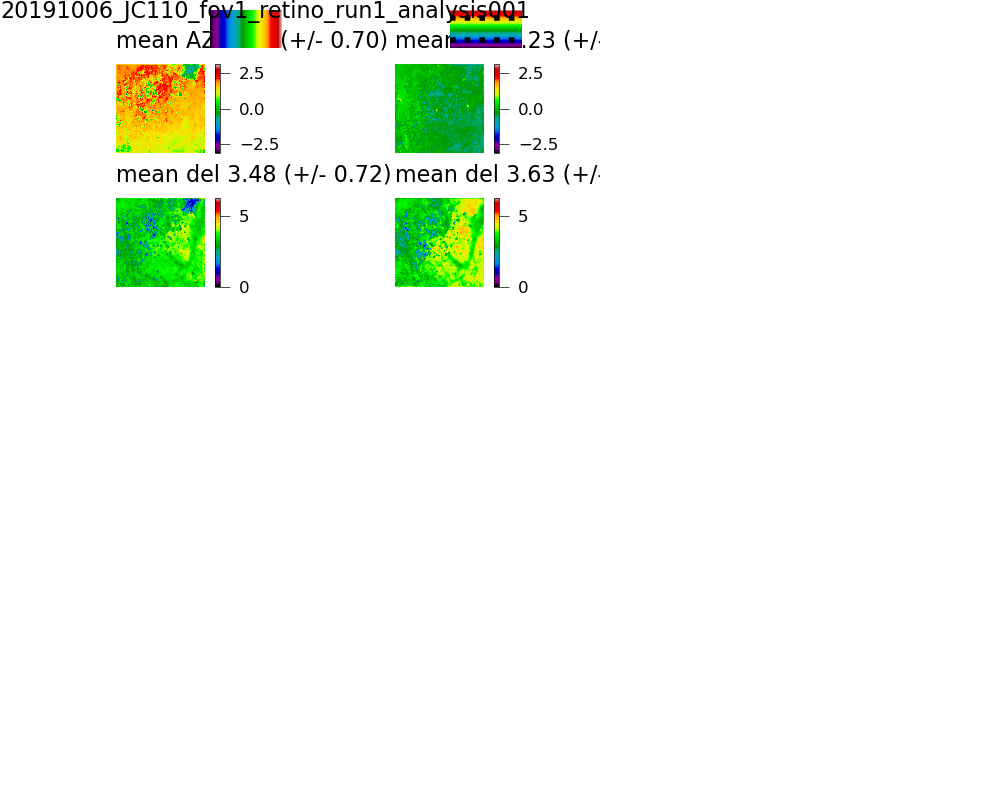

Target: 35 (fwhm=17, k=(1, 1))
start -2.8904886576510838 2.9349468870326967
smoothed 0.359612013361369 2.203937453892138
fillnan 1.111973402879217 2.045741489174493
fillnan 1.111973402879217 2.045741489174493


{'az_gradients': {'image': array([[21.15862106, 21.17521908, 21.1918171 , ..., 37.24210636,
          37.25870439, 37.27530241],
         [21.16079227, 21.17738951, 21.19398674, ..., 37.2435119 ,
          37.26010913, 37.27670636],
         [21.16296349, 21.17955993, 21.19615638, ..., 37.24491743,
          37.26151387, 37.27811032],
         ...,
         [23.70762905, 23.72329941, 23.73896977, ..., 38.89220415,
          38.9078745 , 38.92354486],
         [23.70980027, 23.72546984, 23.7411394 , ..., 38.89360968,
          38.90927925, 38.92494881],
         [23.71197149, 23.72764026, 23.74330904, ..., 38.89501522,
          38.91068399, 38.92635277]]),
  'magnitude': array([[0.01673943, 0.01673933, 0.01673923, ..., 0.01665743, 0.01665736,
          0.0166573 ],
         [0.01673865, 0.01673855, 0.01673844, ..., 0.01665664, 0.01665657,
          0.01665651],
         [0.01673786, 0.01673776, 0.01673766, ..., 0.01665585, 0.01665579,
          0.01665572],
         ...,
         [0.01

In [35]:
sct.load_gradients(dk, va, retinorun='retino_run1', create_new=True,
                    pix_mag_thr=0.00, delay_thr=3, target_sigma_um=35,
                    rootdir=rootdir)

Current run: retino_run1
DATA ID: 20191006_JC110_fov1_retino_run1_analysis001
Original dims: [512, 512]
Data were downsampled by 2.
65536 non-nan of 65536 (thr=0.000)
65536 non-nan of 65536 (thr=0.000)
65536 non-nan of 65536 (thr=0.000)
65536 non-nan of 65536 (thr=0.000)
65536 non-nan of 65536 (thr=0.000)


<IPython.core.display.Javascript object>


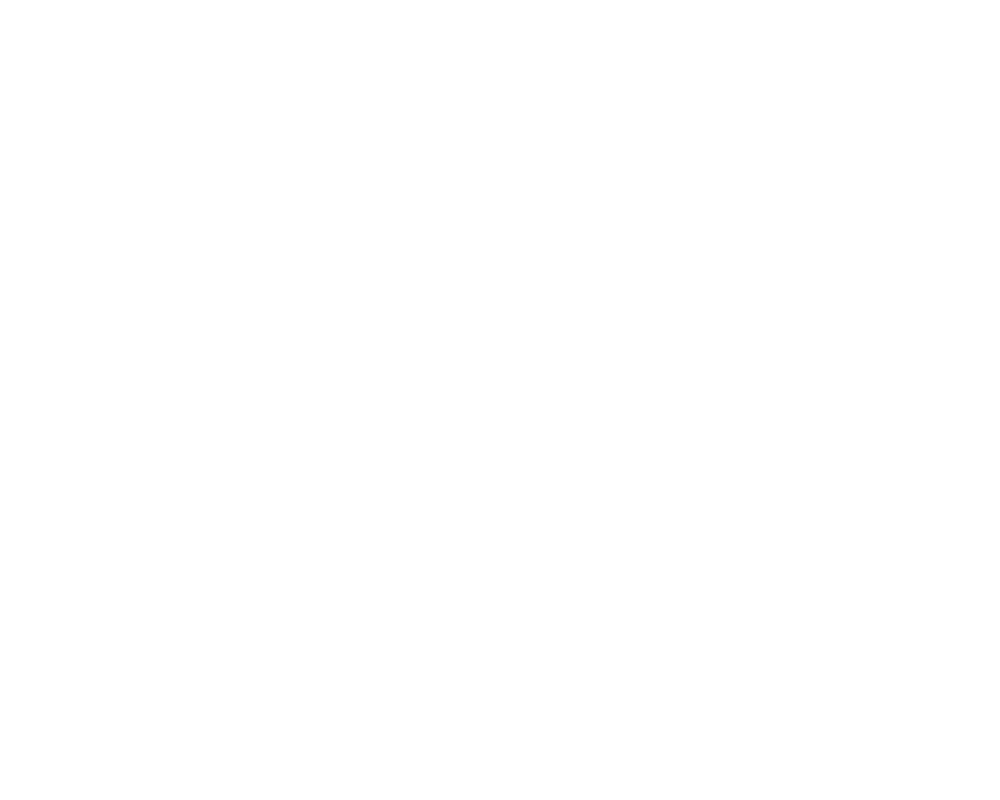

Target: 35 (fwhm=17, k=(1, 1))
start -2.8904886576510838 2.9349468870326967
smoothed 0.359612013361369 2.203937453892138
fillnan 1.111973402879217 2.045741489174493
fillnan 1.111973402879217 2.045741489174493


In [36]:
# Load original image
# retinorun='retino_run1'
# # Load pixel map
AZMAP_NP, ELMAP_NP = sct.load_pixel_maps(dk, va, create_new=True,
                                    pix_mag_thr=0.00, delay_thr=3, 
                                         target_sigma_um=35,
                                    map_type='final', rootdir=rootdir)

#### Check gradients

# Plot

In [37]:
# output dir
rf_str = 'sphr_corrected' if do_spherical_correction else ''
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 'scatter/%s' % rf_str)
print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'retinotopy', 'scatter/%s' % rf_str)
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

print(FIGDIR)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/retinotopy/scatter/


<IPython.core.display.Javascript object>


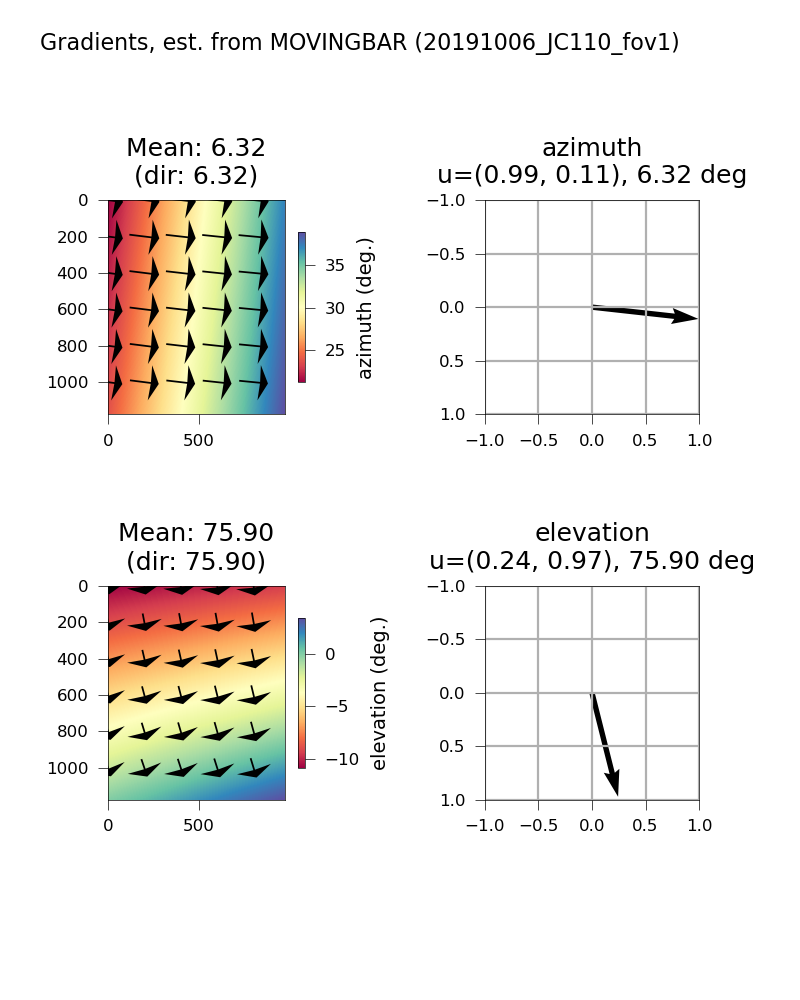

Text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (20191006_JC110_fov1)')

In [42]:
%matplotlib notebook
retinorun='retino_run1'
fig = sct.plot_gradients(dk, va, retinorun, cmap='Spectral', rootdir=rootdir)
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk, fontsize=8)

In [43]:
%matplotlib notebook
fig = sct.plot_gradients(dk, va, retinorun, cmap='Spectral')
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk, fontsize=8)

IndexError: list index out of range

In [63]:
mag_thr=0.02
retinodf_np = sct.load_neuropil_data(dk, retinorun, mag_thr=mag_thr,
            delay_map_thr=1, rootdir=rootdir)
curr_np = retinodf_np[retinodf_np.visual_area==va].copy()          

<IPython.core.display.Javascript object>


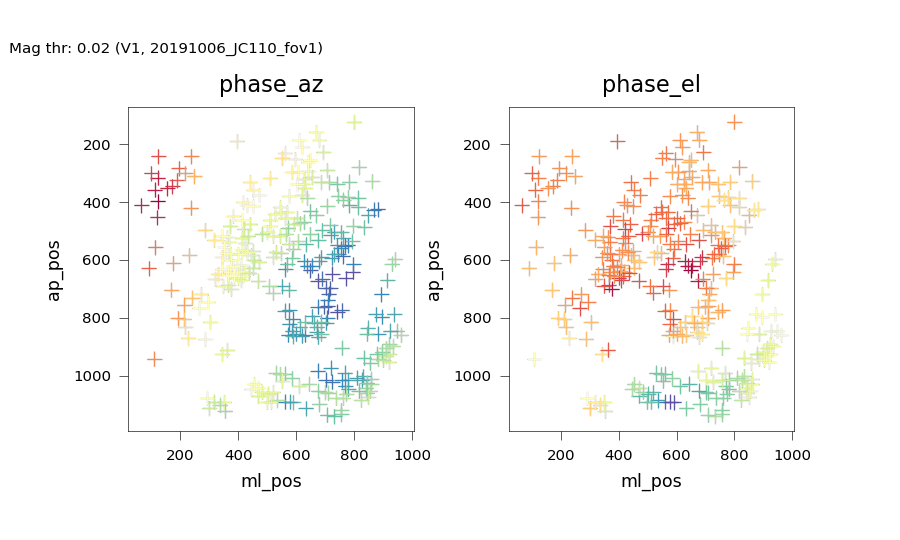

In [65]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(5,3))
ax=axn[0]
for ax, hue_label in zip(axn.flat, ['phase_az', 'phase_el']):
    sns.scatterplot(x='ml_pos', y='ap_pos', 
                    color=[0.5]*3, data=retinodf_np, ax=ax, marker='+')
    sns.scatterplot(x='ml_pos', y='ap_pos', hue=hue_label, 
                    palette='Spectral', data=curr_np, ax=ax, marker='+')
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(hue_label)
    ax.legend_.remove()
fig.text(0.01, 0.9, 'Mag thr: %.2f (%s, %s)' % (mag_thr, va, dk))
pl.subplots_adjust(top=0.8, bottom=0.2)

<IPython.core.display.Javascript object>


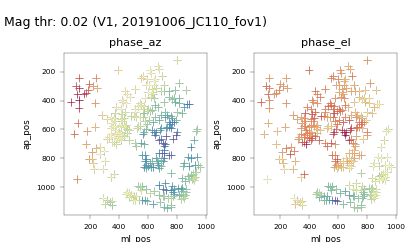

In [198]:
fig, axn = pl.subplots(1,2, figsize=(5,3))
ax=axn[0]
for ax, hue_label in zip(axn.flat, ['phase_az', 'phase_el']):
    sns.scatterplot(x='ml_pos', y='ap_pos', 
                    color=[0.5]*3, data=retinodf_np, ax=ax, marker='+')
    sns.scatterplot(x='ml_pos', y='ap_pos', hue=hue_label, 
                    palette='Spectral', data=curr_np, ax=ax, marker='+')
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(hue_label)
    ax.legend_.remove()
fig.text(0.01, 0.9, 'Mag thr: %.2f (%s, %s)' % (mag_thr, va, dk))
pl.subplots_adjust(top=0.8, bottom=0.2)

In [62]:
importlib.reload(sct)
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [66]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

(1144044, 20)


<IPython.core.display.Javascript object>


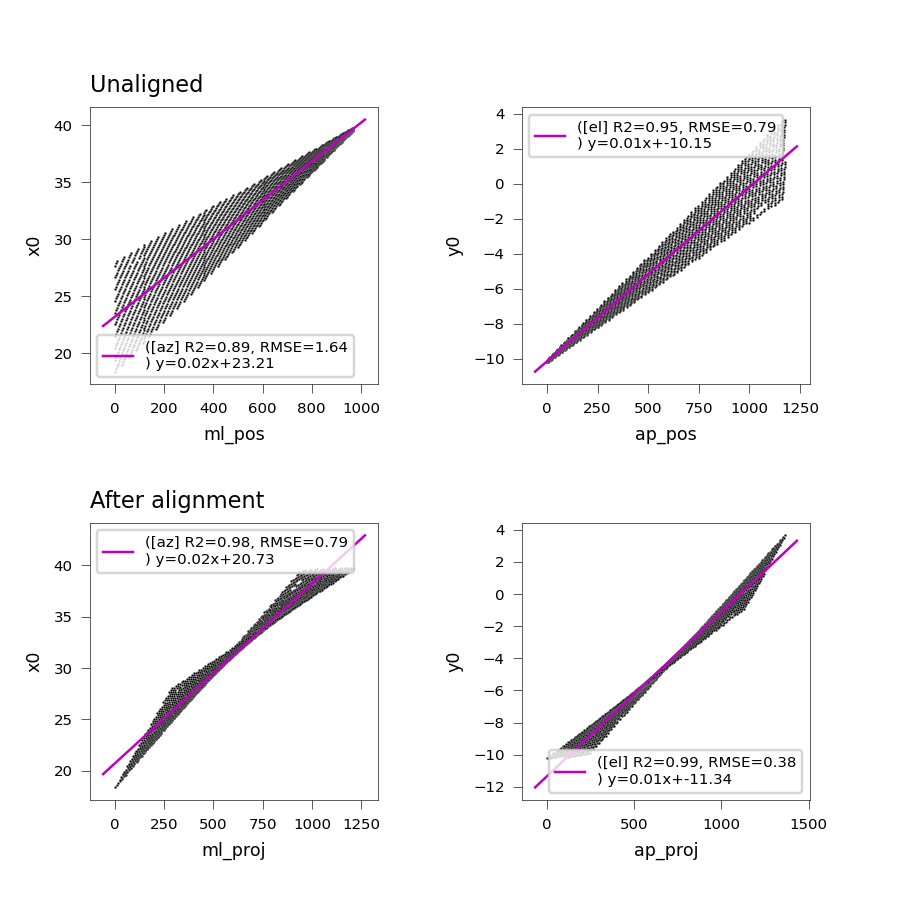

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:828: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(x_vals, y_vals, '--', label=label_str, color=color, ls=ls, lw=lw)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:828: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(x_vals, y_vals, '--', label=label_str, color=color, ls=ls, lw=lw)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:828: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take

In [68]:
aligned_np, REGR_NP, regr_np_meas = sct.transform_and_fit_pixels(dk, va, retinorun,
                                        GVECTORS, create_new=False, rootdir=rootdir)
print(aligned_np.shape)
fig = sct.plot_pre_and_post_pixel_alignment(aligned_np, REGR_NP, regr_np_meas)

(1144044, 20)


<IPython.core.display.Javascript object>


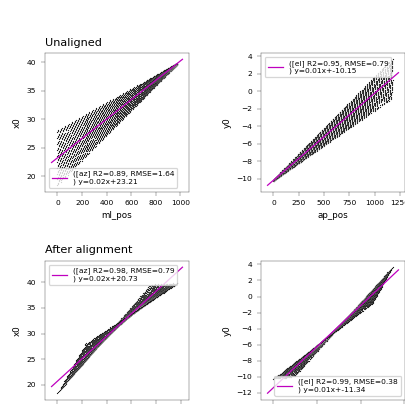

In [200]:
aligned_np, REGR_NP, regr_np_meas = sct.transform_and_fit_pixels(dk, va, retinorun,
                                            GVECTORS, create_new=False)
print(aligned_np.shape)
fig = sct.plot_pre_and_post_pixel_alignment(aligned_np, REGR_NP, regr_np_meas)


In [69]:
REGR_NP

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond
0,0.975632,0.785416,0.0,0.987741,0.017474,20.73423,az
1,0.988224,0.375931,0.0,0.994095,0.010227,-11.34155,el


In [201]:
REGR_NP

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond
0,0.975632,0.785416,0.0,0.987741,0.017474,20.73423,az
1,0.988224,0.375931,0.0,0.994095,0.010227,-11.34155,el


# Get predicted retino pref. from neuropil

#### Load Neuropil data points

In [44]:
%matplotlib notebook
mag_thr=0.02
delay_map_thr=0.5
ds_factor=1

aligned_np, REGR_NP, regr_np_meas = sct.transform_and_fit_neuropil(dk, va, retinorun,
                                                    GVECTORS, mag_thr=mag_thr, 
                                                    delay_map_thr=delay_map_thr, 
                                                    ds_factor=ds_factor,
                                                    abs_value=False, rootdir=rootdir)
print(aligned_np.shape)
# Save
# sct.update_models(dk, va, REGR_NP)

# Q:  why is reversal (LM) wonky
# Q:  fit SOMA to eitehr BAR or TILE gradient
print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

(305, 23)
MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.60994  | 3.63303 | 6.66363e-64 |    0.780987 |     0.0216429 |     24.3276 | az     |
|  1 | 0.530671 | 3.36405 | 1.06165e-51 |    0.728472 |     0.0138091 |    -13.4673 | el     |
ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.650352 | 3.43969 | 4.10747e-71 |    0.806444 |     0.0208268 |     21.8692 | az     |
|  1 | 0.56905  | 3.22357 | 2.49945e-57 |    0.754354 |     0.0138671 |    -15.1758 | el     |


<IPython.core.display.Javascript object>


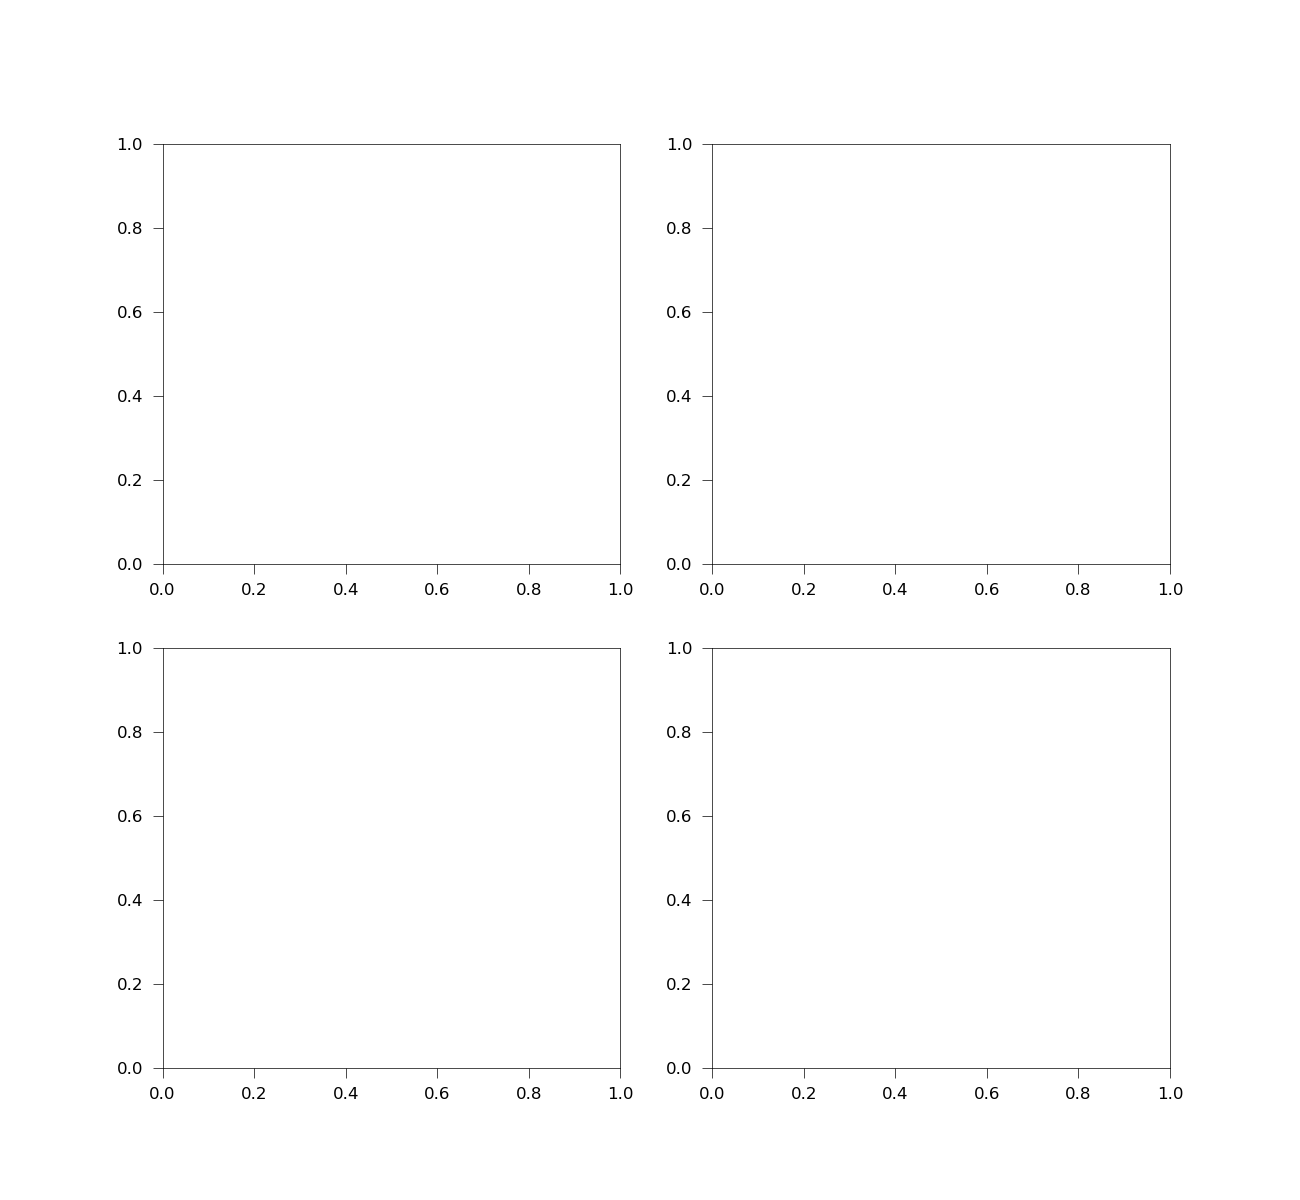

TypeError: regplot() got multiple values for argument 'data'

In [45]:
%matplotlib notebook
fig = sct.plot_measured_and_aligned(aligned_np, REGR_NP, regr_np_meas)
fig.text(0.01, 0.95, \
         'NEUROPIIL: meaured v aligned\n(BAR, %s, %s) - mag_thr=%.2f' % (dk, va, mag_thr))

pl.subplots_adjust(bottom=0.1, right=0.8)

In [46]:
experiment = 'rfs10'
experiment

'rfs10'

In [47]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [48]:
importlib.reload(sct)
#### Align soma coords to gradient
aligned_soma1 = sct.predict_soma_from_gradient(dk, va, REGR_NP, experiment=experiment,
                                   response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction,
                                   abs_value=False, rootdir=rootdir)
aligned_soma1.shape, aligned_soma1[aligned_soma1.reliable].shape

((89, 54), (70, 54))

In [49]:
#### Align soma coords to gradient
s_=[]
for experiment in ['rfs', 'rfs10']:
    soma_ = sct.predict_soma_from_gradient(dk, va, REGR_NP, experiment=experiment,
                                   response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction,
                                   abs_value=False,rootdir=rootdir)
    print(experiment, soma_.shape)
    s_.append(soma_)
soma_tmp = pd.concat(s_, axis=0)

rfs (53, 54)
rfs10 (89, 54)


In [50]:
print(soma_tmp.shape)
53+89

(142, 54)


142

In [51]:
s_=[]
for cell, c_df in soma_tmp.groupby('cell'):
    if len(c_df)>1:
        avg_ = pd.DataFrame(c_df.mean(axis=0)).T
        s_.append(avg_)
    else:
        s_.append(c_df)
aligned_soma = pd.concat(s_, axis=0)
aligned_soma.shape

(99, 54)

In [219]:
projdf = sct.stack_axes(aligned_soma)

In [220]:
projdf.head()

,experiment,visual_area,datakey,cell,r2,theta,offset,amplitude,aniso_index,ratio_xy,...,std,vectorproj,ctx_pos,ctx_proj,predicted_ctx_proj,predicted_rf_pos,predicted_ctx_pos,deg_scatter,dist_scatter,axis
0,rfs10,V1,20191006_JC110_fov1,4.0,0.768773,5.995872,-0.004612,0.081726,-0.096668,1.574417,...,14.034474,13.459182,921.399609,1109.883309,1172.043271,44.835706,1016.898850,1.289809,62.159962,az
1,NaN,NaN,NaN,5.0,0.817547,0.211323,-0.006414,0.118823,-0.095122,1.382015,...,12.483019,12.194405,883.325245,1076.543903,932.085433,44.143919,684.835700,-2.997489,144.458471,az
2,NaN,NaN,NaN,6.0,0.586615,3.132661,-0.005367,0.074118,-0.045543,1.183448,...,10.398985,10.344481,909.977299,1100.358846,887.842391,44.638075,600.154990,-4.409681,212.516455,az
3,rfs,V1,20191006_JC110_fov1,7.0,0.755573,1.886638,-0.011556,0.142085,-0.070332,0.686787,...,9.544189,4.316595,898.554990,1085.530398,896.652339,44.330387,680.531542,-3.919189,188.878059,az
4,NaN,NaN,NaN,11.0,0.644300,3.105377,-0.003707,0.094792,-0.060594,1.385253,...,11.013566,10.432088,900.458708,1093.747790,984.020596,44.500897,753.617340,-2.276821,109.727194,az


#### Load soma - actual retino prefs

MEASURED:
|    |      R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|--------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.57474 | 3.25587 | 1.03333e-19 |    0.758116 |    0.0216734  |    20.2504  | az     |
|  1 | 0.2747  | 2.61106 | 2.58352e-08 |    0.524118 |    0.00769114 |    -4.47448 | el     |
ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.614946 | 3.09814 | 8.09299e-22 |    0.784185 |     0.0205966 |    17.8926  | az     |
|  1 | 0.278533 | 2.60415 | 1.98506e-08 |    0.527762 |     0.0072802 |    -5.44708 | el     |


<IPython.core.display.Javascript object>


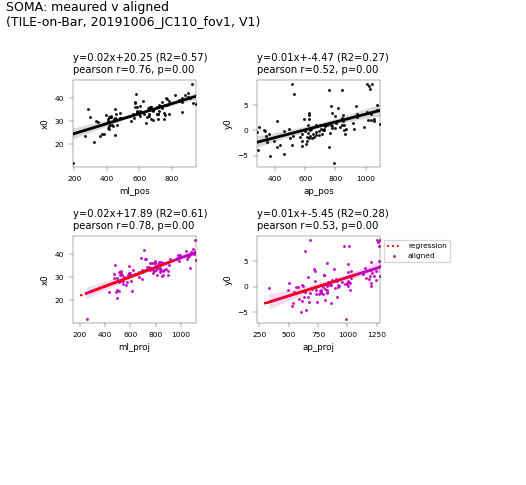

In [210]:
#### Align soma coords to gradient
# aligned_soma = sct.predict_soma_from_gradient(dk, va, REGR_NP, experiment=experiment,
#                                    response_type=response_type, 
#                                    do_spherical_correction=do_spherical_correction,
#                                    abs_value=False)
#### (alrady done above, but get regr. values)
regr_soma_meas = sct.regress_cortex_and_retino_pos(aligned_soma, 
                                                   xvar='pos', model='ridge')
regr_soma_proj = sct.regress_cortex_and_retino_pos(aligned_soma, 
                                                    xvar='proj', model='ridge')
print("MEASURED:")
print(regr_soma_meas.to_markdown())
print("ALIGNED:")
print(regr_soma_proj.to_markdown())
# plot
fig = sct.plot_measured_and_aligned(aligned_soma, regr_soma_proj, regr_soma_meas)
fig.text(0.01, 0.95, 'SOMA: meaured v aligned\n(TILE-on-Bar, %s, %s)' % (dk, va))
pl.subplots_adjust(bottom=0.4, right=0.65)
figname = 'compared_measured_vs_aligned_CTX_to_RETINO_v2'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [105]:
importlib.reload(sct)
importlib.reload(roiutils)

<module 'analyze2p.extraction.rois' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/rois.py'>

<IPython.core.display.Javascript object>


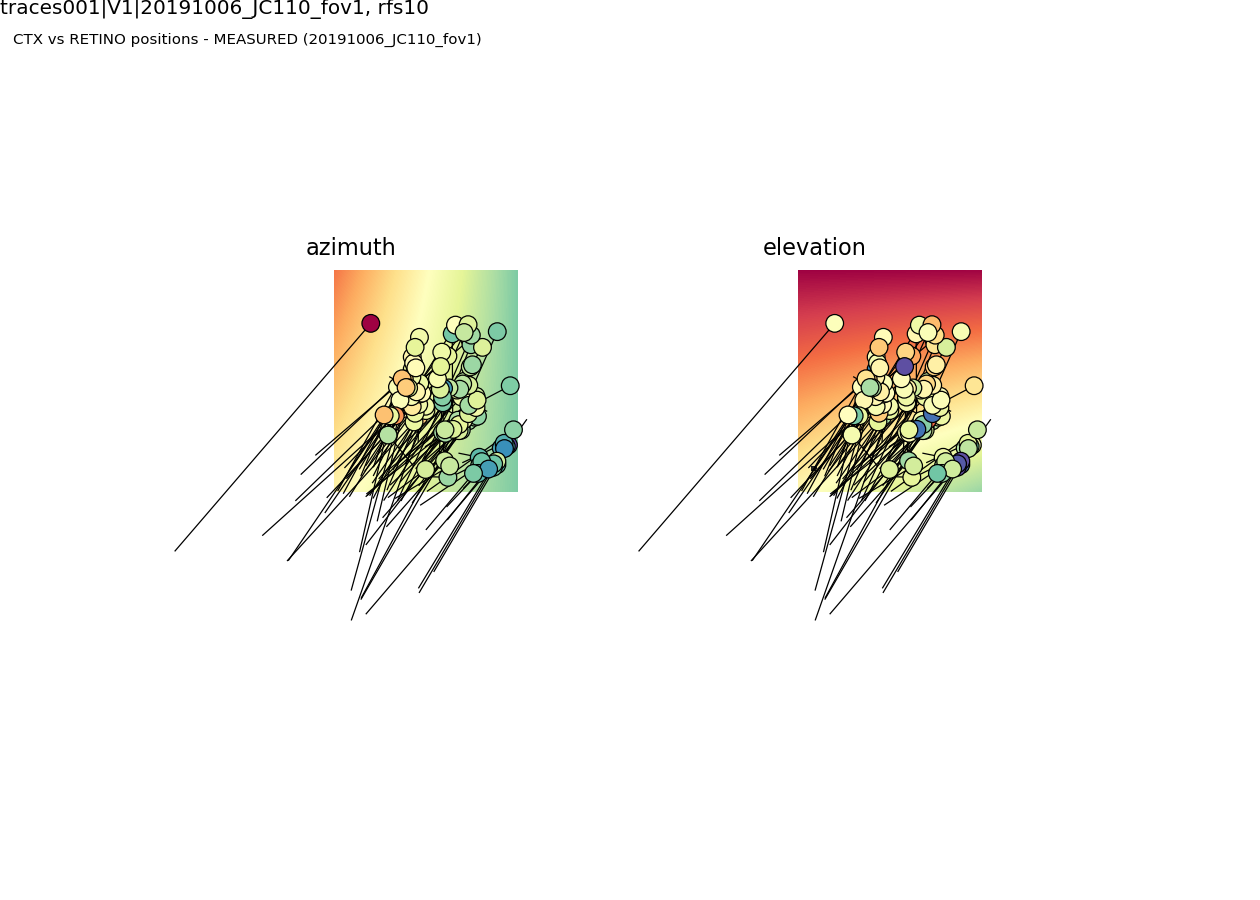

In [221]:
%matplotlib notebook
plotdf = aligned_soma.copy()

fig = sct.overlay_scatter(dk, va, plotdf, #[plotdf.reliable],
                           AZMAP_NP, ELMAP_NP, single_axis=False,
                        experiment=experiment, traceid=traceid,
                           markersize=50, lw=0.5, alpha=1, cmap='Spectral',
                        plot_true=True, plot_predicted=False, plot_lines=True,
                           return_fig=True, rootdir=rootdir)
pl.subplots_adjust(right=0.8)

<IPython.core.display.Javascript object>


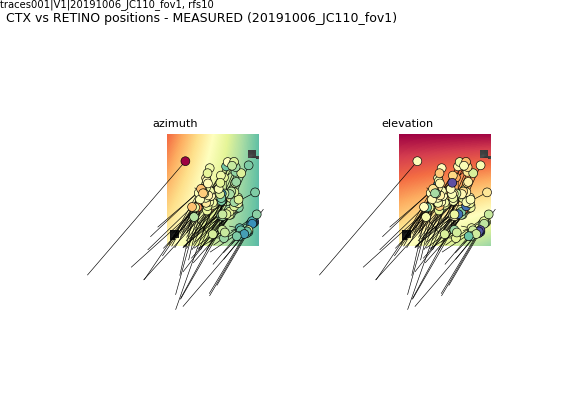

In [212]:
# plotdf = aligned_soma[(aligned_soma.predicted_ap_pos>0) 
#                       & (aligned_soma.predicted_ap_pos<=1200)
#                       & (aligned_soma.predicted_ml_pos<=890)
#                       & (aligned_soma.predicted_ml_pos>0)].copy()
plotdf = aligned_soma.copy()

fig = sct.overlay_scatter(dk, va, plotdf, #[plotdf.reliable],
                           AZMAP_NP, ELMAP_NP, single_axis=False,
                        experiment=experiment, traceid=traceid,
                           markersize=50, lw=0.5, alpha=1, cmap='Spectral',
                        plot_true=True, plot_predicted=False, plot_lines=True,
                           return_fig=True)
pl.subplots_adjust(right=0.8)

## predicted_vs_measured_fov_overlay

In [52]:
zimg, masks, ctrs = roiutils.get_masks_and_centroids(dk, traceid=traceid, 
                                                     rootdir=rootdir)
pixel_size = hutils.get_pixel_size()
zimg_r = retutils.transform_2p_fov(zimg, pixel_size)

In [53]:
inbounds_soma = aligned_soma[(aligned_soma.inbounds==True)
                            & (aligned_soma.reliable)].copy()
# inbounds_soma = aligned_soma[aligned_soma.inbounds==True].copy()
inbounds_soma.shape

inbounds_soma  = aligned_soma.copy() #[aligned_soma.reliable==True].copy()
inbounds_soma.shape

(99, 54)

In [54]:
# Make sure we are in bounds of FOV
ap_lim, ml_lim = AZMAP_NP.shape
print(ap_lim, ml_lim)
incl_plotdf = inbounds_soma[(inbounds_soma['predicted_ml_pos']>=0) 
                            & (inbounds_soma['predicted_ml_pos']<=ml_lim) 
                            & (inbounds_soma['predicted_ap_pos']>=0)
                            & (inbounds_soma['predicted_ap_pos']<=ap_lim)].copy()
incl_plotdf = inbounds_soma.copy()
excl_ixs = [i for i in inbounds_soma.index.tolist() if i not in incl_plotdf.index]
# plotdf = inbounds_soma.copy() 
plotdf = incl_plotdf.iloc[0::].copy()

1177 972


In [55]:
plotdf = inbounds_soma.copy()

In [56]:
vmin = min([np.nanmin(AZMAP_NP), plotdf['x0'].min()])
vmax = max([np.nanmax(AZMAP_NP), plotdf['x0'].max()])
print("AZ: min/max = %.2f, %.2f" % (vmin, vmax))
az_min=np.floor(vmin)
az_max=np.ceil(vmax)

vmin = min([np.nanmin(ELMAP_NP), plotdf['y0'].min()])
vmax = max([np.nanmax(ELMAP_NP), plotdf['y0'].max()])
print("EL: min/max = %.2f, %.2f" % (vmin, vmax))
el_min=np.floor(vmin)
el_max=np.ceil(vmax)

AZ: min/max = 11.94, 46.13
EL: min/max = -10.88, 9.17


In [57]:
# az_min, az_max = (-22.7803813868764, 28.612102845578846)
# el_min, el_max = (-15.776343445468086, 29.288791118991156)

<IPython.core.display.Javascript object>


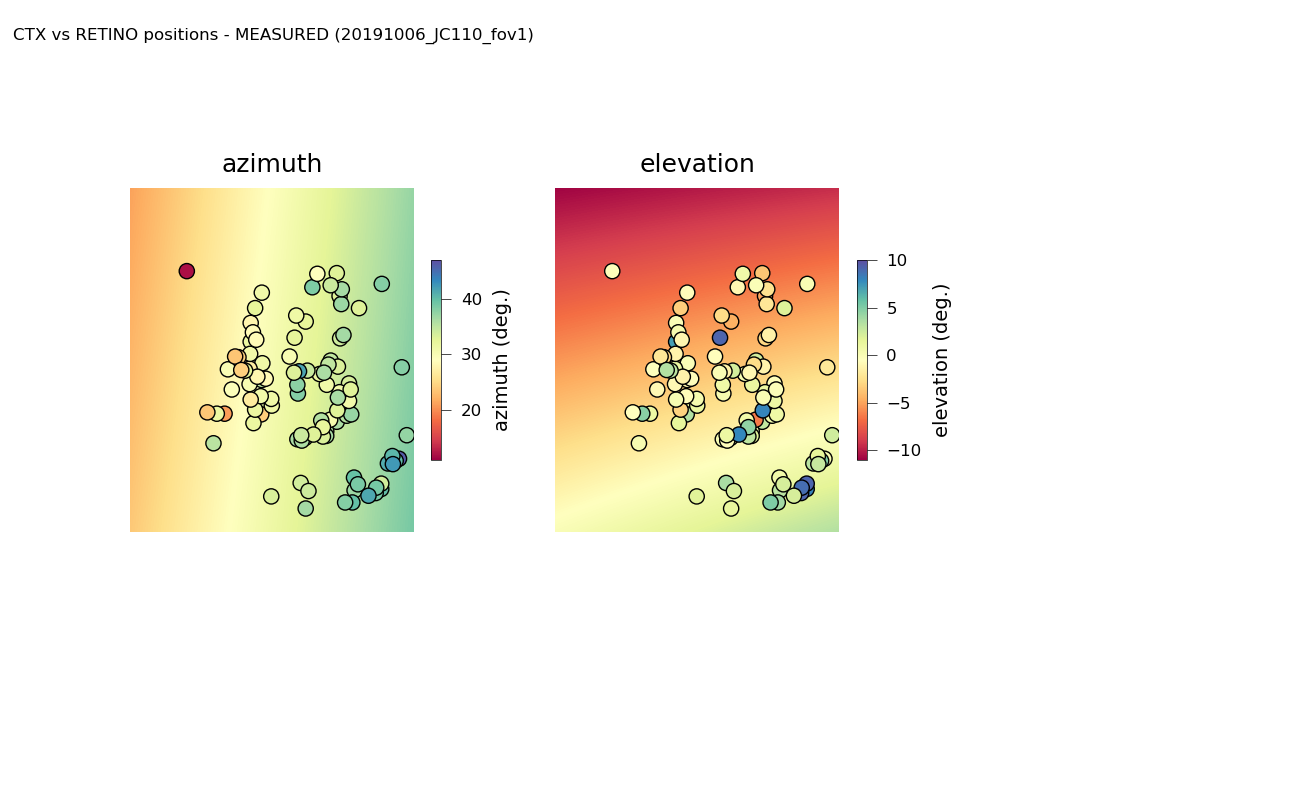

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/retinotopy/scatter/


In [58]:
single_axis=False
roi_interval = 1
plot_true=True
plot_predicted=False
plot_lines=False

if plot_predicted or plot_lines:
    plot_str = 'wpredictions'
else:
    plot_str=''
cmap='Spectral'
color_true='k'
color_predicted='w'

markersize=30
lw=0.5
alpha=1

fig, axn = pl.subplots(1, 2, figsize=(6.5,4))
for ax, cond in zip(axn, ['azimuth', 'elevation']):
    neuropil_map = AZMAP_NP.copy() if cond=='azimuth' else ELMAP_NP.copy()
    retino_label='x0' if cond=='azimuth' else 'y0'
    # Set color limits
    vmin = az_min if cond=='azimuth' else el_min #min([np.nanmin(neuropil_map), plotdf[retino_label].min()])
    vmax = az_max if cond=='azimuth' else el_max #max([np.nanmax(neuropil_map), plotdf[retino_label].max()])
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ax.set_title(cond)
    sm = pl.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    
    ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
    ax.imshow(neuropil_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    ax.figure.colorbar(sm, ax=ax, shrink=0.5, label='%s (deg.)' % cond)
    
    if single_axis:
        pred_x = 'predicted_ml_pos' if cond=='azimuth' else 'ml_pos'
        pred_y = 'predicted_ap_pos' if cond=='elevation' else 'ap_pos'
    else:
        pred_x = 'predicted_ml_pos'
        pred_y = 'predicted_ap_pos'
    if plot_predicted:
        # Plot soma
        sns.scatterplot(x=pred_x, y=pred_y, 
                data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor=color_predicted, zorder=1000) 
    if plot_lines:
        # Plot connecting line
        for (x1, y1), (x2, y2) in zip(\
                plotdf[[pred_x, pred_y]].values,
                plotdf[['ml_pos', 'ap_pos']].values):
            ax.plot([x1, x2], [y1, y2], lw=0.5, markersize=0, color='k')
    if plot_true:
        # Plot soma
        sns.scatterplot(x='ml_pos', y='ap_pos', data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor=color_true, zorder=1000) 
for ax in axn:
    ax.legend_.remove()
    ax.axis('off')
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)
fig.text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (%s)' % dk)

figname = 'scatter_example_%s%s_v2' % (dk, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(FIGDIR)

In [59]:
figname

'scatter_example_20191006_JC110_fov1_v2'

<IPython.core.display.Javascript object>


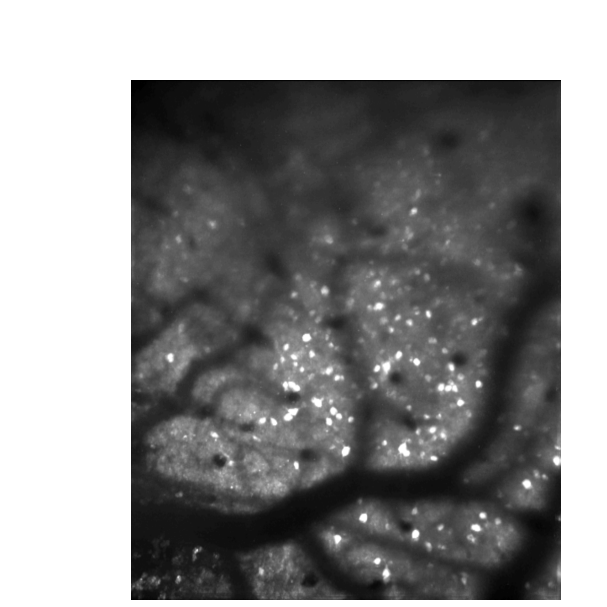

(-0.5, 971.5, 1176.5, -0.5)

In [220]:
fig, ax =pl.subplots(figsize=(5,5), dpi=150)
ax.imshow(zimg_r, cmap='gray')
ax.axis('off')

In [221]:
zimg_r.shape

(1177, 972)

In [222]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/'

# Calculate scatter

In [147]:
# Load scatter analysis for current FOV
scatter0 = sct.load_scatter_results(dk, va, experiment, verbose=False)
# Get cells with reliable fits
fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                do_spherical_correction=do_spherical_correction)
eval_results, eval_params = rfutils.load_eval_results(dk, experiment=experiment, 
                                traceid=traceid, fit_desc=fit_desc)   
reliable_ = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                pass_criterion='position')
# Assign reliable index
found_rois = scatter0['cell'].unique()
scatter0['reliable'] = False
scatter0.loc[scatter0['cell'].isin(reliable_), 'reliable'] = True

In [148]:
# Identify "true deviants"
devs_ = sct.get_deviants_in_fov(dk, va, experiment=experiment, redo_fov=False,
                     traceid=traceid, response_type=response_type, 
                     do_spherical_correction=do_spherical_correction)               
devs_ = devs_.rename(columns={'deviants': 'cell'})
devs_['deviant'] = True
# merge
scatter_ = scatter0.merge(devs_, on=['cell', 'axis'], how='outer')
scatter_ = scatter_.fillna(value=False).sort_values(by=['cell', 'axis'])\
                   .reset_index(drop=True)

In [149]:
# Only get reliable
rois_ = np.intersect1d(reliable_, aligned_soma[aligned_soma.inbounds]['cell'].unique())
boot_ = eval_results['bootdf'][eval_results['bootdf']['cell'].isin(rois_)]
cis_ = eval_results['cis'].loc[rois_]
fitrfs_ = aligned_soma[aligned_soma['cell'].isin(rois_)].copy()
fitrfs_.index = fitrfs_['cell'].values

<IPython.core.display.Javascript object>


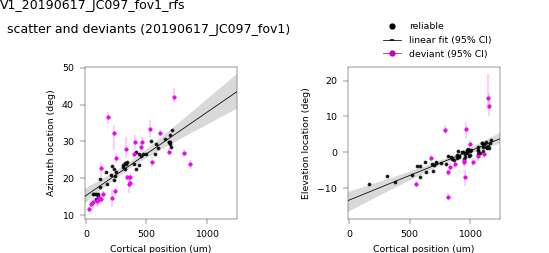

In [150]:
%matplotlib notebook
ci = 0.95
fill_marker=True
deviant_color='magenta'

fig, axn = pl.subplots(1, 2, figsize=(6.5,3), dpi=150, sharex=True)
for ax, cond in zip(axn.flat, ['az', 'el']):
    # Get var names for V1/V2
#     if cond=='az':
#         ax.set_ylim([0, 60])
#     else:
#         #pass
#         ax.set_ylim([-60, -0])
    xname = 'ml_proj' if cond=='az' else 'ap_proj'
    yname = 'x0' if cond=='az' else 'y0'
    ax.set_xlim([-10, 1250])
    # Get projected cortical position
    ax, devs_ = sct.fit_with_deviants(boot_, cis_, fitrfs_, 
                          xname=xname, yname=yname, ax=ax,
                          scatter_kws={'s': 2, 'marker': 'o'}, line_kws={'lw': 0.5}, 
                          deviant_color=deviant_color, legend=cond=='el')
    ylabel='Azimuth' if cond=='az' else 'Elevation'
    ax.set_ylabel('%s location (deg)' % ylabel)
    ax.set_xlabel('Cortical position (um)')
    devdf = pd.DataFrame({'deviants': devs_})
    devdf['cond'] = cond
    ax.set_box_aspect(1)

leg_h = pplot.custom_legend_markers(colors=['k', 'k', 'm'],
                    labels=['reliable', 'linear fit (95% CI)', 'deviant (95% CI)'],
                    markers=['o', '_', 'o'], lws=[0, 0.5, 0.5])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='lower right',
          frameon=False, fontsize=6, markerscale=0.5)
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.35, top=0.8, wspace=0.5)

fig.text(0.01, 0.9, 'scatter and deviants (%s)' % dk, fontsize=8)
pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))

# figname = 'deviants_example_%s' % dk
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))


<IPython.core.display.Javascript object>


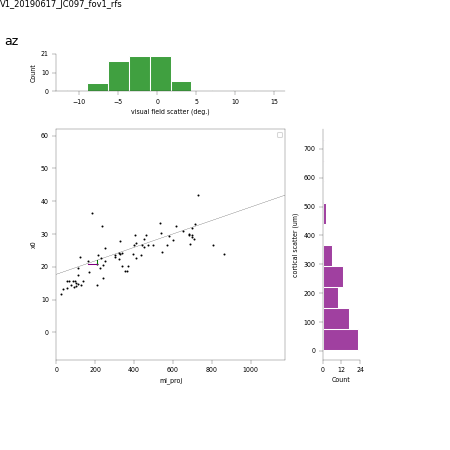

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


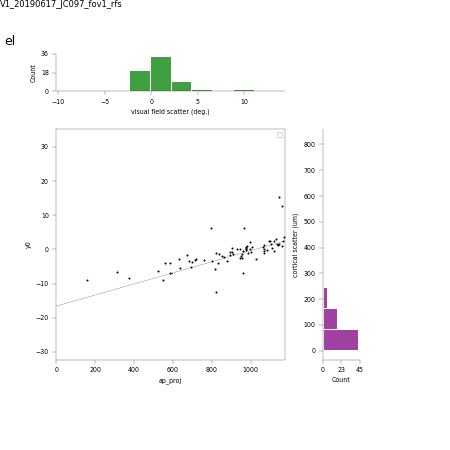

No handles with labels found to put in legend.


In [151]:
sz = 3
lw=0.5
nbins=10
color1='purple'
color2='green'

for cond in ['az', 'el']:
    dist_lim = ml_lim if cond=='az' else ap_lim
    fig = sct.plot_scatter_and_marginals(fitrfs_, REGR_NP, roi_to_label=None, #93,
                                         cond=cond,
                                        xlim=ap_lim, ylim=None, lw=1)
    pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))
    fig.text(0.01, 0.9, '%s' % cond, fontsize=12)
    pl.subplots_adjust(bottom=0.2, right=0.8)
    figname = 'scatter_marginals_%s_%s' % (cond, dk)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    #pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))


In [143]:
fitrfs_[fitrfs_['cell']==78]

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2,cell,visual_area,...,predicted_ap_proj,predicted_x0,predicted_y0,predicted_ml_pos,predicted_ap_pos,deg_scatter_x0,deg_scatter_y0,dist_scatter_ml,dist_scatter_ap,inbounds


In [303]:
int(np.where(fitrfs_['cell']==78)[0])



37